In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 39.9 MB/s eta 0:00:00


In [ ]:
!pip install geopandas


In [ ]:
# all the raster images have different minimum and maximum values therefore we need to resample or make same size before we go FINAL RUSLE multiplication

import numpy as np
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio import warp

def resample_tiff(input_path, output_path, reference_tiff):
    with rasterio.open(reference_tiff) as ref_ds:
        ref_data = ref_ds.read(1)
        ref_transform = ref_ds.transform
        ref_crs = ref_ds.crs
        ref_height, ref_width = ref_data.shape

    with rasterio.open(input_path) as ds:
        data = ds.read(1)
        resampled_data = np.empty_like(ref_data)

        rasterio.warp.reproject(
            source=data,
            destination=resampled_data,
            src_transform=ds.transform,
            src_crs=ds.crs,
            dst_transform=ref_transform,
            dst_crs=ref_crs,
            resampling=Resampling.nearest  # or use Resampling.bilinear for a smoother result
        )

        profile = ds.profile  # Accessing properties before closing the dataset

    profile.update({
        'transform': ref_transform,
        'crs': ref_crs,
        'width': ref_width,
        'height': ref_height
    })

    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(resampled_data, 1)

# Example usage
reference_file = r'/content/gdrive/MyDrive/Project_RUSLE/Arcgis_LS_factor1.tif'


#input
path_r = r'/content/gdrive/MyDrive/Project_RUSLE/rainfall_erosivity.tif'
path_k = r'/content/gdrive/MyDrive/Project_RUSLE/factorK_export.tif'
path_ls = r'/content/gdrive/MyDrive/Project_RUSLE/Arcgis_LS_factor1.tif'
path_c = r'/content/gdrive/MyDrive/Project_RUSLE/factorC.tif'
path_p = r'/content/gdrive/MyDrive/Project_RUSLE/new_P_factor_lulc1.tif'

#output

o_path_r = r'/content/gdrive/MyDrive/Project_RUSLE/r2.tif'
o_path_k = r'/content/gdrive/MyDrive/Project_RUSLE/k2.tif'
o_path_ls = r'/content/gdrive/MyDrive/Project_RUSLE/ls2.tif'
o_path_c = r'/content/gdrive/MyDrive/Project_RUSLE/c2.tif'
o_path_p = r'/content/gdrive/MyDrive/Project_RUSLE/p2.tif'







resample_tiff(path_r, o_path_r, reference_file)
resample_tiff(path_k, o_path_k,reference_file)
resample_tiff(path_ls, o_path_ls, reference_file)
resample_tiff(path_c, o_path_c, reference_file)
resample_tiff(path_p, o_path_p, reference_file)


In [ ]:
# FINAL RUSLE
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
def read_tiff(file_path):
  with rasterio.open(file_path) as src:
    array = src.read(1) # Assuming single-band TIFFs
  return array
def write_tiff(file_path, data_array, template_tiff):
  with rasterio.open(template_tiff) as template_src:
    profile = template_src.profile.copy()
  with rasterio.open(file_path, 'w', **profile) as dst:
    dst.write(data_array, 1)
# Replace these paths with your actual file paths
path_r = r'/content/gdrive/MyDrive/Project_RUSLE/r2.tif'
path_k = r'/content/gdrive/MyDrive/Project_RUSLE/k2.tif'
path_ls = r'/content/gdrive/MyDrive/Project_RUSLE/ls2.tif'
path_c = r'/content/gdrive/MyDrive/Project_RUSLE/c2.tif'
path_p = r'/content/gdrive/MyDrive/Project_RUSLE/p2.tif'

# Read TIFF files
array_r = read_tiff(path_r)
array_k = read_tiff(path_k)
array_ls = read_tiff(path_ls)
array_c = read_tiff(path_c)
array_p = read_tiff(path_p)
# Perform multiplication
result_array = array_r * array_k * array_ls * array_c * array_p
# Write result to a new TIFF file
output_tiff_path = r'/content/gdrive/MyDrive/Project_RUSLE/rusle.tif'
template_tiff_path = r'/content/gdrive/MyDrive/Project_RUSLE/Arcgis_LS_factor1.tif'
write_tiff(output_tiff_path, result_array, template_tiff_path)

/usr/local/lib/python3.10/dist-packages/numpy/core/_asarray.py:126: RuntimeWarning: overflow encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)


rusle map


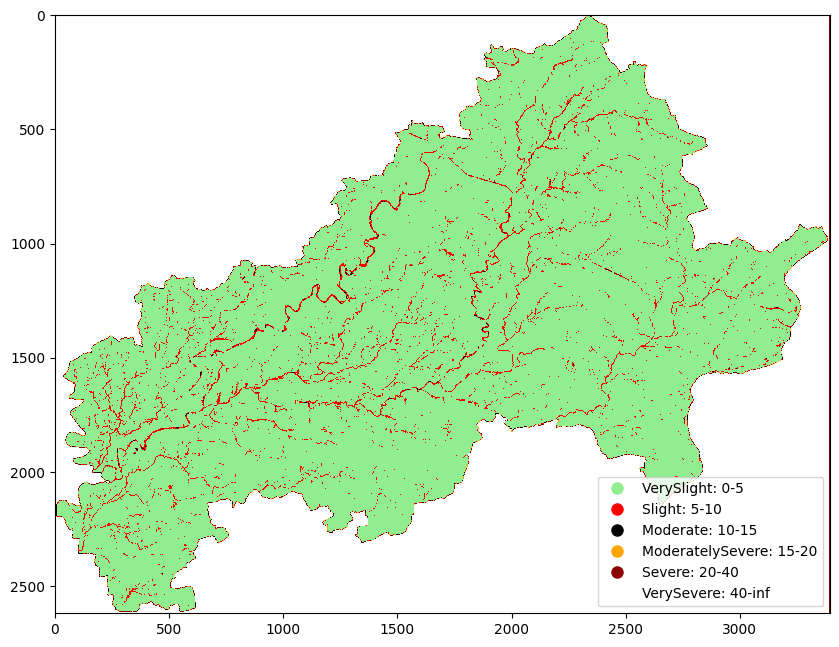

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from matplotlib.colors import ListedColormap

# Specify the path to your input raster file
input_raster_path = r'/content/gdrive/MyDrive/Project_RUSLE/rusle.tif'

# Open the raster file
with rasterio.open(input_raster_path) as src:
    # Read the raster data
    data = src.read(1, masked=True)  # Assuming the data is in the first band

    # Define the categories and corresponding color map
    categories = ['VerySlight','Slight','Moderate', 'ModeratelySevere', 'Severe','VerySevere']
    color_values = [0, 5, 10, 15, 20,40, np.inf]
    colors = ['lightgreen', 'red', 'black', 'orange', 'darkred','white']

    # Create a colormap
    cmap = ListedColormap(colors)

    # Create a legend
    legend_labels = [f'{categories[i]}: {color_values[i]}-{color_values[i+1]}' for i in range(len(categories))]
    legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=legend_labels[i]) for i in range(len(colors))]

    # Categorize the data
    category_data = np.digitize(data, bins=color_values, right=True)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the categorized data
    im = ax.imshow(category_data, cmap=cmap)

    # Add the legend
    # ax.legend(handles=legend, loc='lower right', bbox_to_anchor=(1, 1))
    ax.legend(handles=legend, loc='lower right')


    # Show the plot
    plt.show()
    # output_image_path = r'/content/gdrive/MyDrive/Rusle_Project Input/OUTPUT/rusle_map.tif'
    # plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0.1)




